# 프로젝트 : Segmentation map으로 도로 이미지 만들기

- 아래 사이트를 참고하여 Segmentation map을 이용하여 도로 이미지를 만들어봅시다.
- 참고 사이트: [Tensorflow Pix2Pix Tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko)

## 1. 데이터 준비하기

In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

from tensorflow import data

from tensorflow.keras import layers, Input, Model

from tensorflow.keras import losses
from tensorflow.keras import optimizers

In [3]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


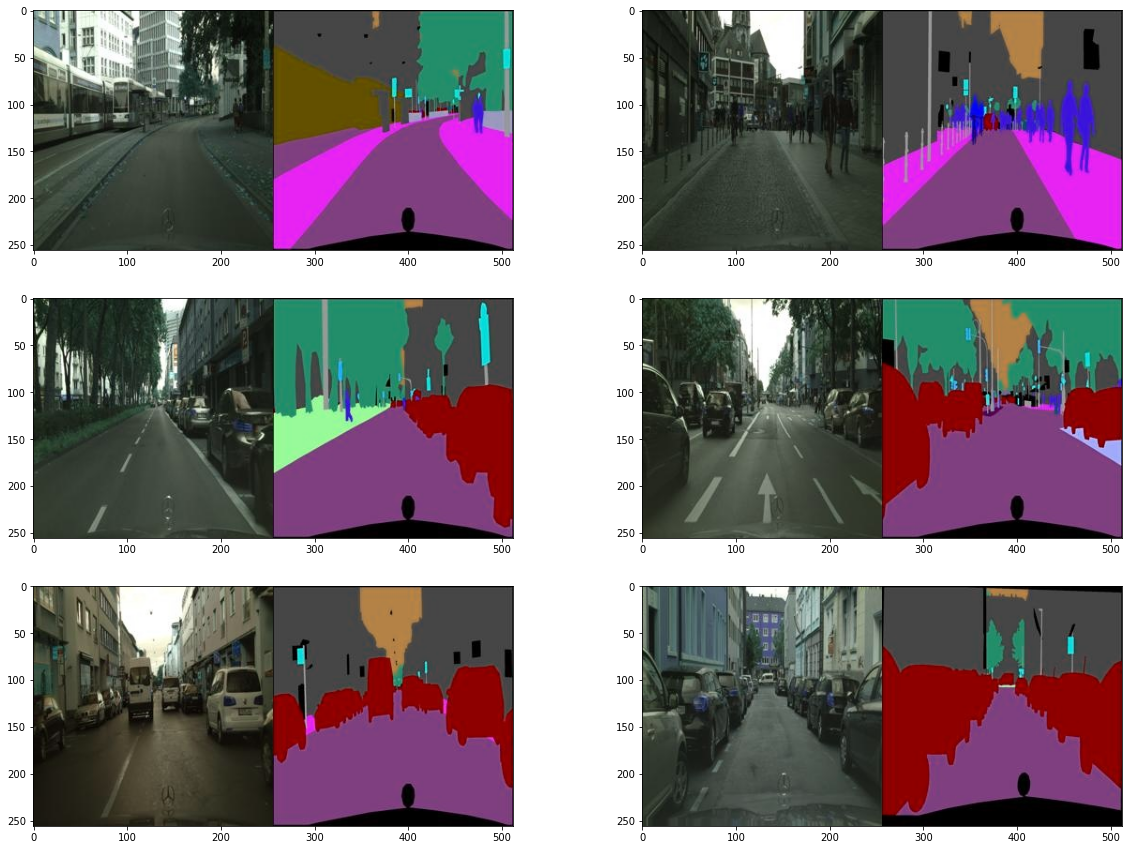

In [4]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [5]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


In [6]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    predicted = img[:, :w, :] 
    predicted = tf.cast(predicted, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(colored), normalize(predicted)

Text(0.5, 1.0, 'Ground Truth')

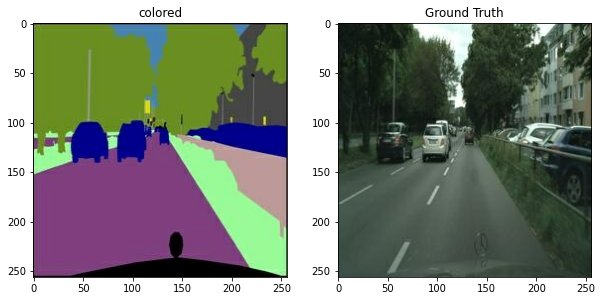

In [7]:
f = data_path + os.listdir(data_path)[1]
colored, predicted = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(colored)); plt.title('colored')
plt.subplot(1,2,2); plt.imshow(denormalize(predicted)); plt.title('Ground Truth')

In [9]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

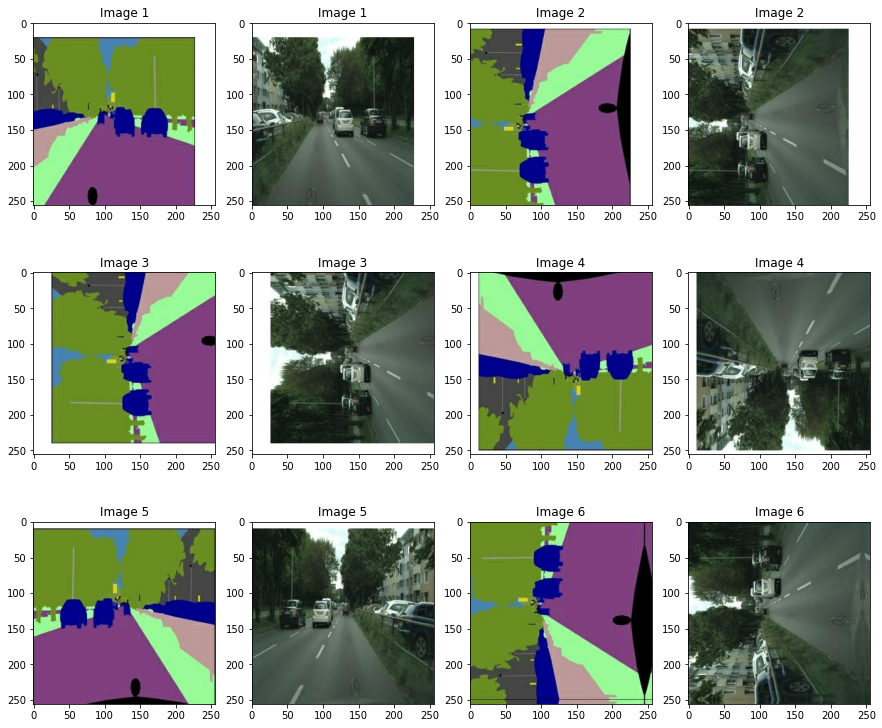

In [10]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_colored, augmented_predicted = apply_augmentation(colored, predicted)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_predicted)); plt.title(f"Image {img_n}")
    img_n += 1

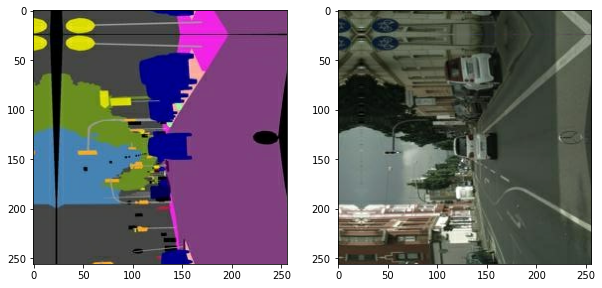

In [11]:
def get_train(img_path):
    colored, predicted = load_img(img_path)
    colored, predicted = apply_augmentation(colored, predicted)
    return colored, predicted

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
colored, predicted = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(colored[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(predicted[0].astype(np.uint8))

## 2. Generator 구성하기

In [12]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [13]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [14]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## Discriminator 구성하기

In [15]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [16]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [17]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [18]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

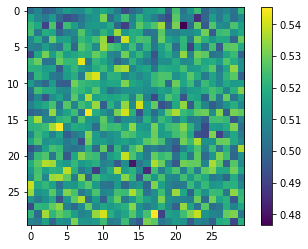

In [19]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 4. 학습 및 테스트

In [26]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [27]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [28]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [29]:
EPOCHS = 20 #약 30분 정도 소요 됩니다.

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8798                     
L1_loss:0.3504                     
Discriminator_loss:1.2582

EPOCH[1] - STEP[20]                     
Generator_loss:1.0274                     
L1_loss:0.2112                     
Discriminator_loss:1.3289

EPOCH[1] - STEP[30]                     
Generator_loss:0.8813                     
L1_loss:0.1752                     
Discriminator_loss:1.3679

EPOCH[1] - STEP[40]                     
Generator_loss:0.9097                     
L1_loss:0.1608                     
Discriminator_loss:1.2972

EPOCH[1] - STEP[50]                     
Generator_loss:0.7091                     
L1_loss:0.2310                     
Discriminator_loss:1.4048

EPOCH[1] - STEP[60]                     
Generator_loss:0.8897                     
L1_loss:0.1857                     
Discriminator_loss:1.0632

EPOCH[1] - STEP[70]                     
Generator_loss:1.0819                     
L1_loss:0.1929                    

EPOCH[3] - STEP[70]                     
Generator_loss:2.1556                     
L1_loss:0.1601                     
Discriminator_loss:0.6931

EPOCH[3] - STEP[80]                     
Generator_loss:1.9916                     
L1_loss:0.2370                     
Discriminator_loss:0.3080

EPOCH[3] - STEP[90]                     
Generator_loss:0.9155                     
L1_loss:0.1677                     
Discriminator_loss:0.8643

EPOCH[3] - STEP[100]                     
Generator_loss:1.1233                     
L1_loss:0.1539                     
Discriminator_loss:0.7430

EPOCH[3] - STEP[110]                     
Generator_loss:0.9024                     
L1_loss:0.1842                     
Discriminator_loss:1.0359

EPOCH[3] - STEP[120]                     
Generator_loss:1.9892                     
L1_loss:0.1710                     
Discriminator_loss:0.4880

EPOCH[3] - STEP[130]                     
Generator_loss:2.0295                     
L1_loss:0.2070                

EPOCH[5] - STEP[130]                     
Generator_loss:2.2340                     
L1_loss:0.1519                     
Discriminator_loss:1.2966

EPOCH[5] - STEP[140]                     
Generator_loss:3.0556                     
L1_loss:0.1749                     
Discriminator_loss:0.8027

EPOCH[5] - STEP[150]                     
Generator_loss:1.3174                     
L1_loss:0.1652                     
Discriminator_loss:0.6889

EPOCH[5] - STEP[160]                     
Generator_loss:0.2302                     
L1_loss:0.2071                     
Discriminator_loss:1.9052

EPOCH[5] - STEP[170]                     
Generator_loss:1.2700                     
L1_loss:0.1927                     
Discriminator_loss:0.4955

EPOCH[5] - STEP[180]                     
Generator_loss:0.6796                     
L1_loss:0.1747                     
Discriminator_loss:0.8975

EPOCH[5] - STEP[190]                     
Generator_loss:3.1447                     
L1_loss:0.1718             

EPOCH[7] - STEP[190]                     
Generator_loss:2.3705                     
L1_loss:0.1788                     
Discriminator_loss:0.6462

EPOCH[7] - STEP[200]                     
Generator_loss:1.3649                     
L1_loss:0.1909                     
Discriminator_loss:0.4688

EPOCH[7] - STEP[210]                     
Generator_loss:1.1313                     
L1_loss:0.1799                     
Discriminator_loss:0.8201

EPOCH[7] - STEP[220]                     
Generator_loss:1.0093                     
L1_loss:0.1750                     
Discriminator_loss:1.3882

EPOCH[7] - STEP[230]                     
Generator_loss:0.7675                     
L1_loss:0.1819                     
Discriminator_loss:1.0714

EPOCH[7] - STEP[240]                     
Generator_loss:0.7555                     
L1_loss:0.1856                     
Discriminator_loss:0.9701

EPOCH[7] - STEP[250]                     
Generator_loss:2.1201                     
L1_loss:0.1526             

EPOCH[9] - STEP[250]                     
Generator_loss:2.0580                     
L1_loss:0.1773                     
Discriminator_loss:1.3822

EPOCH[10] - STEP[10]                     
Generator_loss:2.4677                     
L1_loss:0.1858                     
Discriminator_loss:0.3951

EPOCH[10] - STEP[20]                     
Generator_loss:0.9305                     
L1_loss:0.1841                     
Discriminator_loss:0.8031

EPOCH[10] - STEP[30]                     
Generator_loss:1.0316                     
L1_loss:0.1582                     
Discriminator_loss:0.8845

EPOCH[10] - STEP[40]                     
Generator_loss:1.7846                     
L1_loss:0.1804                     
Discriminator_loss:0.7145

EPOCH[10] - STEP[50]                     
Generator_loss:1.0791                     
L1_loss:0.1713                     
Discriminator_loss:0.9932

EPOCH[10] - STEP[60]                     
Generator_loss:1.8376                     
L1_loss:0.1881             

EPOCH[12] - STEP[60]                     
Generator_loss:0.8763                     
L1_loss:0.1654                     
Discriminator_loss:0.7111

EPOCH[12] - STEP[70]                     
Generator_loss:1.3236                     
L1_loss:0.1726                     
Discriminator_loss:0.5674

EPOCH[12] - STEP[80]                     
Generator_loss:1.3324                     
L1_loss:0.1459                     
Discriminator_loss:1.1578

EPOCH[12] - STEP[90]                     
Generator_loss:0.8750                     
L1_loss:0.2072                     
Discriminator_loss:1.5344

EPOCH[12] - STEP[100]                     
Generator_loss:1.5427                     
L1_loss:0.1727                     
Discriminator_loss:0.4237

EPOCH[12] - STEP[110]                     
Generator_loss:1.6633                     
L1_loss:0.1932                     
Discriminator_loss:0.5372

EPOCH[12] - STEP[120]                     
Generator_loss:1.4392                     
L1_loss:0.1544          

EPOCH[14] - STEP[120]                     
Generator_loss:0.3782                     
L1_loss:0.1757                     
Discriminator_loss:1.6960

EPOCH[14] - STEP[130]                     
Generator_loss:1.6094                     
L1_loss:0.1759                     
Discriminator_loss:0.3972

EPOCH[14] - STEP[140]                     
Generator_loss:0.4001                     
L1_loss:0.1814                     
Discriminator_loss:1.4188

EPOCH[14] - STEP[150]                     
Generator_loss:0.4340                     
L1_loss:0.1689                     
Discriminator_loss:1.6944

EPOCH[14] - STEP[160]                     
Generator_loss:1.0970                     
L1_loss:0.1798                     
Discriminator_loss:0.5857

EPOCH[14] - STEP[170]                     
Generator_loss:0.7486                     
L1_loss:0.1815                     
Discriminator_loss:0.8754

EPOCH[14] - STEP[180]                     
Generator_loss:1.2073                     
L1_loss:0.1755      

EPOCH[16] - STEP[180]                     
Generator_loss:0.5337                     
L1_loss:0.1795                     
Discriminator_loss:1.1344

EPOCH[16] - STEP[190]                     
Generator_loss:0.7977                     
L1_loss:0.1958                     
Discriminator_loss:0.8883

EPOCH[16] - STEP[200]                     
Generator_loss:0.7032                     
L1_loss:0.2043                     
Discriminator_loss:0.9810

EPOCH[16] - STEP[210]                     
Generator_loss:1.0670                     
L1_loss:0.1697                     
Discriminator_loss:0.9520

EPOCH[16] - STEP[220]                     
Generator_loss:1.0937                     
L1_loss:0.1495                     
Discriminator_loss:1.4107

EPOCH[16] - STEP[230]                     
Generator_loss:1.8614                     
L1_loss:0.1583                     
Discriminator_loss:1.2900

EPOCH[16] - STEP[240]                     
Generator_loss:0.5315                     
L1_loss:0.1877      

KeyboardInterrupt: 

In [ ]:
test_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'

for i in range(5):
    f = test_path + os.listdir(test_path)[i]
    colored, predicted = load_img(f)

    pred = generator(tf.expand_dims(colored, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(colored)); plt.title('colored')
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image')
    plt.subplot(1,3,3); plt.imshow(denormalize(predicted)); plt.title('Ground Truth')